  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.8310955243820976 cfg =  {'model_name': 'gpt2-medium', 'inference_max_len': 30, 'dataset_datapoints_num': 1000}


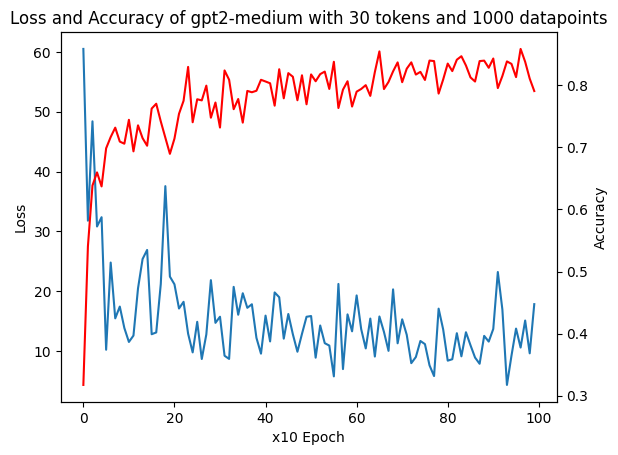

In [47]:
from exps.gpt2 import GPT2Wrapper
from typing import Any
import functools
import torch
import time
import os
from torch.profiler import profile, record_function, ProfilerActivity

# inference_max_len = 50 # 每个输入用于推理的句子的最大长度

class Model(GPT2Wrapper):
    def __init__(self, model_name, inference_max_len):
        super().__init__(model_name)
        self.iml = inference_max_len

    def register_forward_hook(self, container: Any):
        def get_h0_input(module, input, output, container):
            container[:, 0] = input[0][0, :self.iml].detach()

        def hook(module, input, output, i, container):
            container[:, i + 1] = output[0][0, :self.iml].detach()
        
        handle = self.model.transformer.h[0].register_forward_hook(
            functools.partial(get_h0_input, container=container)
        )
        self.handles.append(handle)

        for i in range(self.n_layer):
            handle = self.model.transformer.h[i].register_forward_hook(
                functools.partial(hook, i=i, container=container)
            )
            self.handles.append(handle)

        # 传进来一个 max_len * (n_layer + 1) 的 tensor
        # 第 1～n_layer 行是 h0～hn 的输出
        # 第 0 行是 h0 的输入
            
    def task_inference(self, input):
        input_tokens = input.split(' ')
        input_tokens = input_tokens[:self.iml*2]
        input = ' '.join(input_tokens)
        # check if input > max_len tokens
        token_num = self.encode_input(input).shape[1]
        if token_num < self.iml:
            return None
        
        container = torch.zeros(self.iml, self.n_layer + 1, self.n_embd)
        container = self.inference(input, container) # [max_len, n_layer + 1, n_embd]
        original_shape = container.shape
        container = container.view(original_shape[0] * original_shape[1], original_shape[2]) # [max_len * (n_layer + 1), n_embd]

        # 现在 container 相当于是 max_len * (n_layer + 1) 个向量，每个向量是 n_embd 维的
        # 现在希望再拓展两个维度，变成 max_len * (n_layer + 1) 个 (n_embd + 2) 维的向量，后两维分别是 layer 和 position

        layer = torch.arange(self.n_layer + 1).repeat(self.iml).view(-1, 1).float() # [max_len * (n_layer + 1), 1]
        position = torch.arange(self.iml).repeat(self.n_layer + 1).view(-1, 1).float() # [max_len * (n_layer + 1), 1]
        container = torch.cat([container, layer, position], dim=1) # [max_len * (n_layer + 1), n_embd + 2]

        # 现在 container 是 max_len * (n_layer + 1) 个 (n_embd + 2) 维的向量
        return container

from torchtext import datasets
import random

def make_dataset(num, dataset='IMDB'):
    if dataset == 'IMDB':
        train_iter, _ = datasets.IMDB()
        train_data = list(train_iter)
        train_data: list[str] = [x[1] for x in train_data]
    else:
        raise ValueError('Unknown dataset')

    datapoints_num = len(train_data)

    assert num <= datapoints_num, 'Number of datapoints is too large'

    random.shuffle(train_data)
    train_data = train_data[:num]

    return train_data

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

config = {
    'model_name': 'gpt2-medium',
    'inference_max_len': 30,
    'dataset_datapoints_num': 1000
}

model_name = config['model_name']
inference_max_len = config['inference_max_len']
dataset_datapoints_num = config['dataset_datapoints_num']

# 创建模型
model = Model(model_name, inference_max_len)
tokenizer = model.tokenizer

# 数据集创建
train_data = make_dataset(dataset_datapoints_num)
dataset = torch.zeros(dataset_datapoints_num * inference_max_len * (model.n_layer + 1), model.n_embd + 2).cuda()
processed_idx = 0

for i, x in enumerate(train_data):
    container = model.task_inference(x)
    if container is None:
        print(f'Warning: {i}th data is too short')
        continue

    dataset[processed_idx:processed_idx+inference_max_len*(model.n_layer+1)] = container
    processed_idx += inference_max_len * (model.n_layer + 1)

dataset = dataset[:processed_idx]

# 训练线性回归模型
n_samples, n_features = config['dataset_datapoints_num'], model.n_embd  # 样本数和特征数
n_classes = model.n_layer + 1  # 类别数

X_train, X_test, Y_train, Y_test = train_test_split(dataset[:, :-2], dataset[:, -2], test_size=0.2, random_state=0)
# X_train = X_train.cpu()
# X_test = X_test.cpu()
Y_train = Y_train.long()
Y_test = Y_test.long()
# 数据加载器
dataset = TensorDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size=8192, shuffle=True)

# 定义模型
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_input_features, n_output_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(n_input_features, n_output_classes)

    def forward(self, x):
        return self.linear(x)

model = LogisticRegressionModel(n_features, n_classes).cuda()

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
n_epochs = 1000  # 训练轮数
batch_size = 1024  # 批处理大小
n_samples = X_train.size(0)  # 样本数
# use tqdm to show progress, and collect loss, draw a loss curve finally
loss_list = []
acc_list = []
for epoch in tqdm(range(n_epochs)):
    indices = torch.randperm(n_samples)
    X_train = X_train[indices]
    Y_train = Y_train[indices]

    for i in range(0, n_samples, batch_size):
        # 计算批处理的结束索引
        end = min(i + batch_size, n_samples)
        
        # 选取当前批次的数据并迁移至GPU
        X = X_train[i:end]
        Y = Y_train[i:end]
        # forward pass
        start = time.time()
        Yhat = model(X)
        loss = criterion(Yhat, Y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        loss_list.append(loss.item())
        Y_test_hat = model(X_test)
        _, Y_test_hat = Y_test_hat.max(1)
        acc = (Y_test_hat == Y_test).sum().item() / Y_test.size(0)
        acc_list.append(acc)

# 训练完毕，创建一个新的画布，绘制 loss 曲线（左）和 accuracy 曲线（右）
plt.figure()
plt.xlabel('x10 Epoch')
plt.ylabel('Loss')
plt.plot(loss_list)
plt.twinx()
plt.ylabel('Accuracy')
plt.plot(acc_list, 'r')
plt.title(f'Loss and Accuracy of {model_name} with {inference_max_len} tokens and {dataset_datapoints_num} datapoints')
plt.savefig(f'loss_{model_name}_{inference_max_len}_{dataset_datapoints_num}.png')

# 测试模型
model.eval()
with torch.no_grad():
    Yhat = model(X_test)
    _, Yhat = Yhat.max(1)
    accuracy = (Yhat == Y_test).sum().item() / Y_test.size(0)
    print(f'Accuracy: {accuracy}', "cfg = ", config)

In [48]:
model.eval()
with torch.no_grad():
    Yhat = model(X_test)
    _, Yhat = Yhat.max(1)
    accuracy = (Yhat == Y_test).sum().item() / Y_test.size(0)
    print(f'Accuracy: {accuracy}', "cfg = ", config)

Accuracy: 0.8310955243820976 cfg =  {'model_name': 'gpt2-medium', 'inference_max_len': 30, 'dataset_datapoints_num': 1000}


In [49]:
import torch
import itertools

def evaluate_model_with_masked_features(model, X_test, Y_test, features_to_mask):
    """
    评估屏蔽特定特征后的模型准确率。
    
    :param model: 训练好的模型
    :param X_test: 测试数据
    :param Y_test: 测试标签
    :param features_to_mask: 要屏蔽的特征列表
    :return: 准确率
    """
    # 创建一个新的X_test的副本来屏蔽特征
    X_test_masked = X_test.clone()
    # 屏蔽特定的特征
    for feature in features_to_mask:
        X_test_masked[:, feature] = 0  # 假设特征是在第二维度
    
    # 评估模型
    model.eval()
    with torch.no_grad():
        Yhat = model(X_test_masked)
        _, predicted = Yhat.max(1)
        accuracy = (predicted == Y_test).sum().item() / Y_test.size(0)
    
    return accuracy

# 要屏蔽的特征维度
features = [591, 690, 581, 239]

# 生成所有可能的屏蔽组合
combinations = []
for r in range(1, len(features) + 1):
    combinations.extend(list(itertools.combinations(features, r)))

# 计算每种组合下的准确率
accuracies = {}
for combo in combinations:
    accuracy = evaluate_model_with_masked_features(model, X_test, Y_test, combo)
    accuracies[combo] = accuracy
    print(f'Accuracy with features {combo} masked: {accuracy}')


Accuracy with features (591,) masked: 0.8300200400801603
Accuracy with features (690,) masked: 0.8303540414161656
Accuracy with features (581,) masked: 0.8308216432865732
Accuracy with features (239,) masked: 0.831309285237141
Accuracy with features (591, 690) masked: 0.8292518370073481
Accuracy with features (591, 581) masked: 0.8297394789579158
Accuracy with features (591, 239) masked: 0.8300801603206412
Accuracy with features (690, 581) masked: 0.8304074816299265
Accuracy with features (690, 239) masked: 0.8306613226452906
Accuracy with features (581, 239) masked: 0.831182364729459
Accuracy with features (591, 690, 581) masked: 0.8293787575150301
Accuracy with features (591, 690, 239) masked: 0.8294789579158317
Accuracy with features (591, 581, 239) masked: 0.8300267201068804
Accuracy with features (690, 581, 239) masked: 0.8307615230460922
Accuracy with features (591, 690, 581, 239) masked: 0.8295123580494322


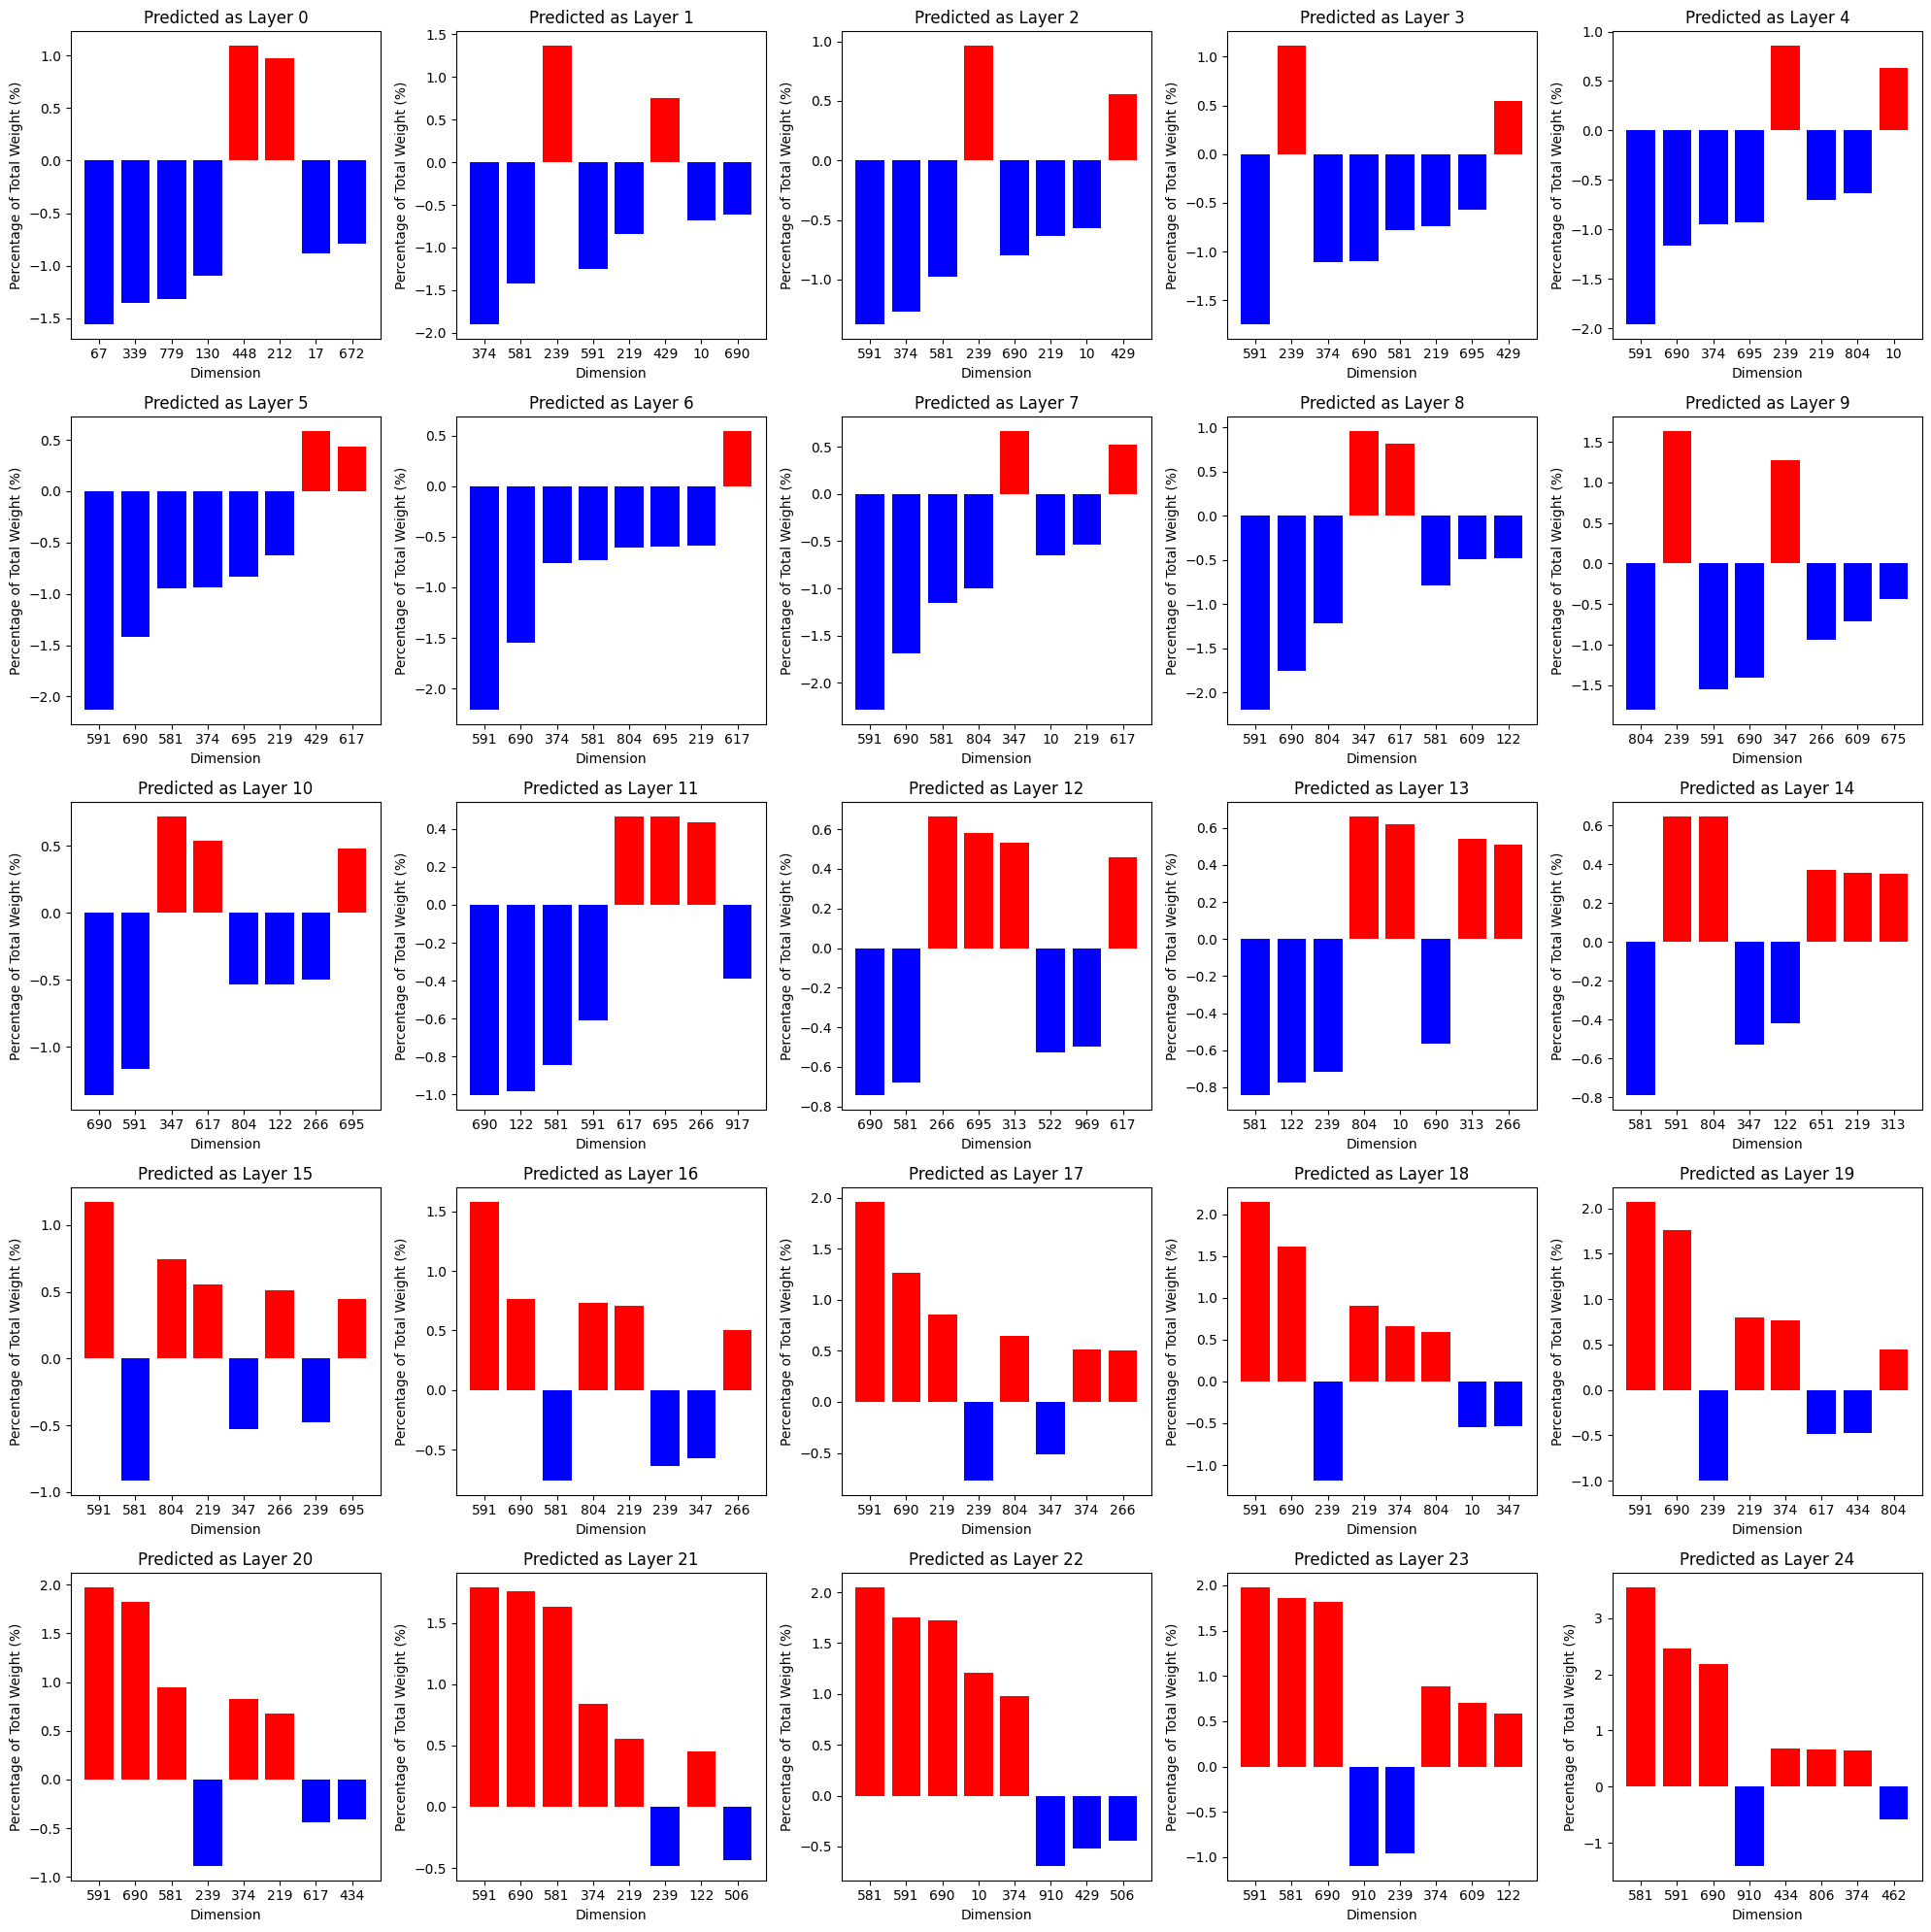

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

weights = model.linear.weight.cpu().detach().numpy()

fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25):
    row = weights[i]
    # 获取前8个最大贡献维度的索引和值
    top_indices = np.argsort(np.abs(row))[-8:][::-1]  # 逆序以确保最大的在前
    top_values = row[top_indices]
    top_percentages = top_values / np.sum(np.abs(row)) * 100  # 计算占所有权重的百分比

    ax = axs[i // 5, i % 5]
    colors = ['red' if val > 0 else 'blue' for val in top_values]  # 正贡献用蓝色，负贡献用红色
    ax.bar(range(1, 9), top_percentages, color=colors)
    ax.set_xticks(range(1, 9))
    ax.set_xticklabels(top_indices + 1)  # 显示实际维度序号（从1开始）
    ax.set_title(f'Predicted as Layer {i}')
    ax.set_xlabel('Dimension')
    ax.set_ylabel('Percentage of Total Weight (%)')

plt.tight_layout()
plt.show()

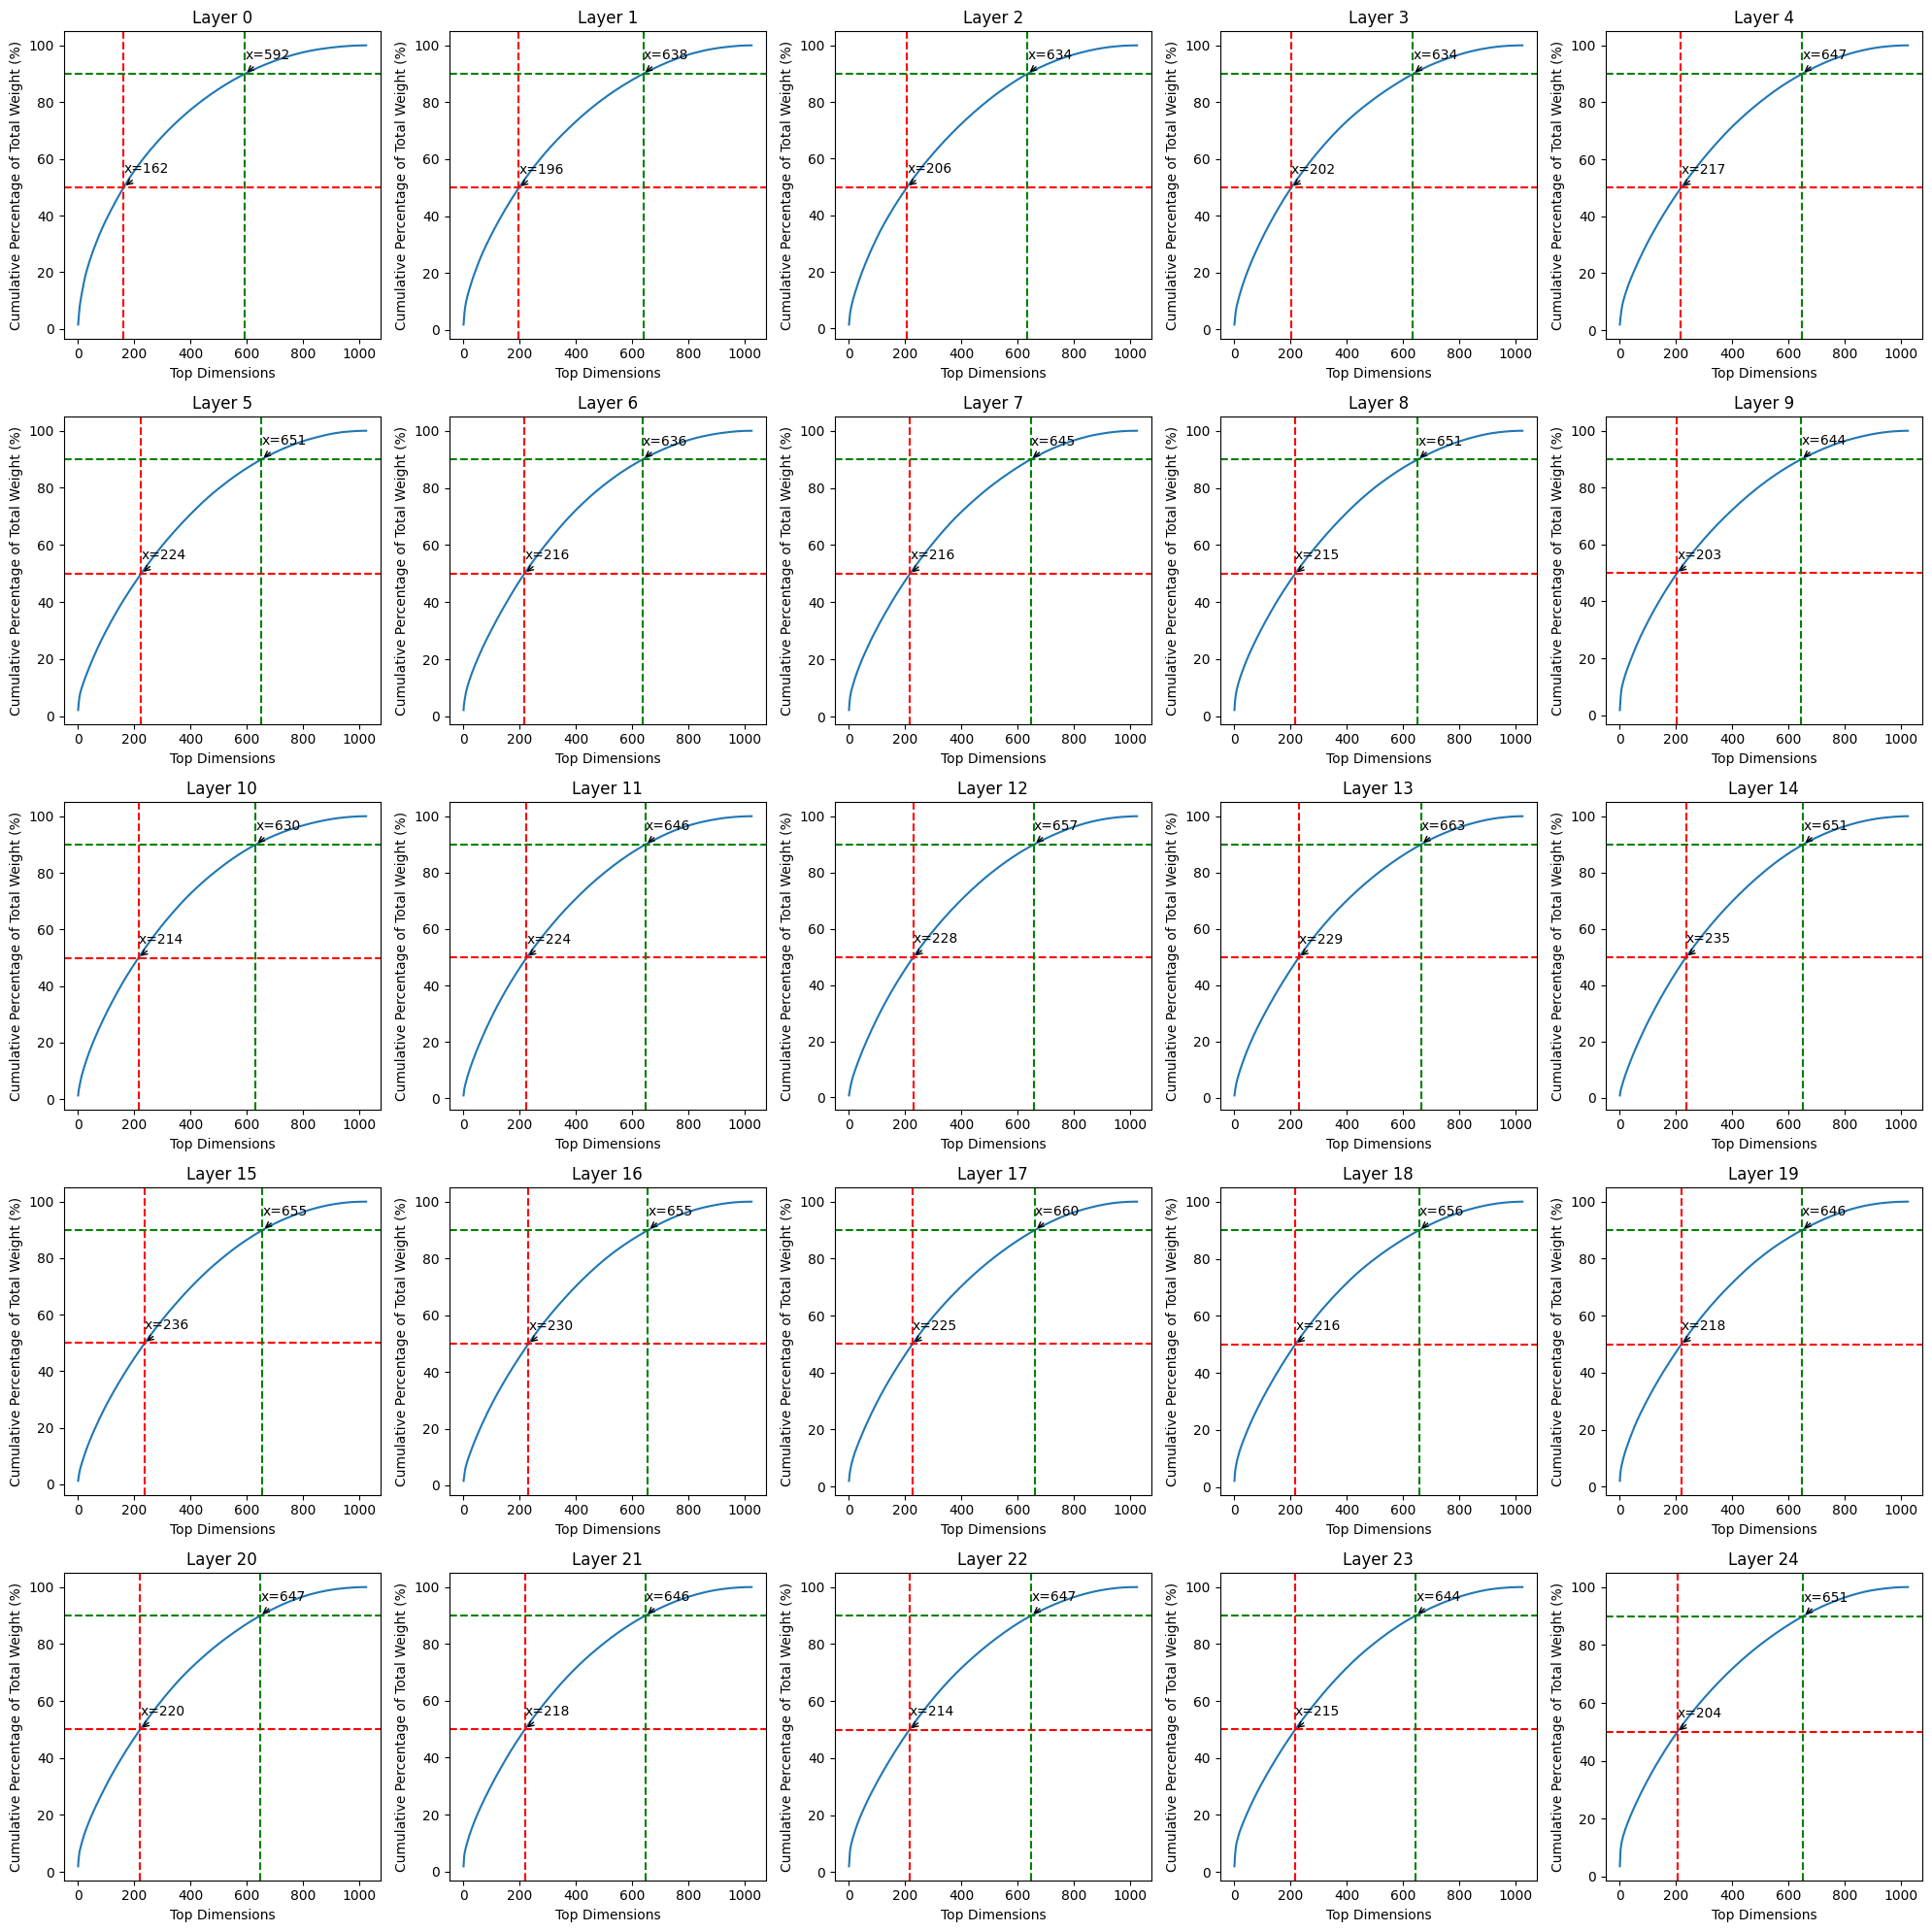

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

weights = model.linear.weight.cpu().detach().numpy()
weights = np.abs(weights)

fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25):
    row = weights[i]
    top_indices = np.argsort(np.abs(row))[::-1]  # 逆序以确保最大的在前
    top_values = row[top_indices]
    top_percentages = top_values / np.sum(np.abs(row)) * 100  # 计算占所有权重的百分比
    # 计算前多少个维度的权重占了总权重的多少百分比
    cumulative_percentages = np.cumsum(top_percentages)

    ax[i // 5, i % 5].plot(cumulative_percentages)
    ax[i // 5, i % 5].set_title(f'Layer {i}')
    ax[i // 5, i % 5].set_xlabel('Top Dimensions')
    ax[i // 5, i % 5].set_ylabel('Cumulative Percentage of Total Weight (%)')

    # 百分之50纵坐标处画一个虚线，并据此找到交点，并向x轴作垂线，并在交点处画一个点，标记出交点的横坐标
    ax[i // 5, i % 5].axhline(y=50, color='r', linestyle='--')
    idx = np.argwhere(np.diff(np.sign(cumulative_percentages - 50)))[0]
    ax[i // 5, i % 5].axvline(x=idx, color='r', linestyle='--')
    # 标注交点的横坐标
    ax[i // 5, i % 5].annotate(f'x={idx[0]}', xy=(idx, cumulative_percentages[idx]), xytext=(idx, cumulative_percentages[idx] + 5),
                              arrowprops=dict(facecolor='black', arrowstyle='->'))

    #90%
    ax[i // 5, i % 5].axhline(y=90, color='g', linestyle='--')
    idx = np.argwhere(np.diff(np.sign(cumulative_percentages - 90)))[0]
    ax[i // 5, i % 5].axvline(x=idx, color='g', linestyle='--')
    # 标注交点的横坐标
    ax[i // 5, i % 5].annotate(f'x={idx[0]}', xy=(idx, cumulative_percentages[idx]), xytext=(idx, cumulative_percentages[idx] + 5),
                              arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.tight_layout()




In [77]:
# 将模型权重整体乘一个系数（从0.98到0.5），并评估模型准确率，绘制曲线（整体缩放不影响，已略过）

# 构造一个AG_NEWS数据集，用IMDB的模型测试
from exps.gpt2 import GPT2Wrapper
from typing import Any
import functools
import torch
import time
import os
from torch.profiler import profile, record_function, ProfilerActivity
from torchtext import datasets
import random

train_iter, _ = datasets.AG_NEWS()
train_data = list(train_iter)
train_data: list[str] = [x[1] for x in train_data]

used_data = []
for i, x in enumerate(train_data):
    if len(x.split(' ')) > 60:
        used_data.append(x)
    print(f'Processed {i}th data', end='\r')
    if len(used_data) >= 1000:
        break

train_data = used_data

datapoints_num = len(train_data)

random.shuffle(train_data)
train_data = train_data[:config['dataset_datapoints_num']]

gpt2model = Model('gpt2-medium', config['inference_max_len'])

dataset = torch.zeros(config['dataset_datapoints_num'] * inference_max_len * (gpt2model.n_layer + 1), (gpt2model.n_embd+2)).cuda()
processed_idx = 0

for i, x in enumerate(train_data):
    container = gpt2model.task_inference(x)
    if container is None:
        print(f'Warning: {i}th data is too short')
        continue

    dataset[processed_idx:processed_idx+inference_max_len*(gpt2model.n_layer+1)] = container
    processed_idx += inference_max_len * (gpt2model.n_layer + 1)

dataset = dataset[:processed_idx]

X_train, X_test, Y_train, Y_test = train_test_split(dataset[:, :-2], dataset[:, -2], test_size=0.2, random_state=0)

Y_train = Y_train.long()
Y_test = Y_test.long()

# 测试模型
model.eval()
with torch.no_grad():
    Yhat = model(X_test)
    _, Yhat = Yhat.max(1)
    accuracy = (Yhat == Y_test).sum().item() / Y_test.size(0)
    print(f'Accuracy: {accuracy}', "cfg = ", config)

Accuracy: 0.6627266666666667 cfg =  {'model_name': 'gpt2-medium', 'inference_max_len': 30, 'dataset_datapoints_num': 1000}
